## Data Analysis 3: Prediction and Introduction to Machine Learning
## Assignment 2

### Finding fast growing firms 2025: Predictive Models

#### prepared by Alina Imanakhunova and Sabira Onbayeva

In [ ]:
# Environment setup

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from statsmodels.nonparametric.smoothers_lowess import lowess

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
N_SPLITS = 5

In [ ]:
# Data loading
# note: make sure to run prep notebook first

DATA_PATH = "data/bisnode_firms_clean_growth.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())

Shape: (17927, 73)


,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,flag_miss_liq_assets_bs,flag_miss_curr_assets_bs,flag_miss_fixed_assets_bs,flag_miss_intang_assets_bs,flag_miss_share_eq_bs,flag_miss_profit_loss_year_pl,flag_miss_profit_loss_year_pl_sq,flag_miss_inc_bef_tax_pl,flag_miss_foreign_management,flag_miss_gender_m
0,2012,1001541,2012-01-01,2012-12-31,481.481476,9629.629883,1303.703735,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,2012,1002029,2012-01-01,2012-12-31,14929.629883,203885.187500,120444.453125,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,2012,1011889,2012-01-01,2012-12-31,36625.925781,160166.671875,18911.111328,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,2012,1014183,2012-01-01,2012-12-31,12551.851562,199903.703125,8274.074219,0.0,7.407407,7.407407,...,0,0,0,0,0,0,0,0,0,0
4,2012,1018301,2012-01-01,2012-12-31,0.000000,1811.111084,592.592590,0.0,11.111111,11.111111,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Basic target check
TARGET = "fast_growth"

print("Target share:")
display(df[TARGET].value_counts(normalize=True).round(3))

Target share:


fast_growth
0    0.8
1    0.2
Name: proportion, dtype: float64

## Exploratory Data Analysis

In [4]:
# Descriptives (numeric) and missingness
num_preview = [
    "ln_sales_mil", "age", "profit_loss_year_pl", "liq_assets_bs", "share_eq_bs", "ceo_age"
]
num_preview = [c for c in num_preview if c in df.columns]

display(df[num_preview].describe().T)
display(df[num_preview].isna().mean().sort_values(ascending=False).round(3))

,count,mean,std,min,25%,50%,75%,max
ln_sales_mil,17927.0,-2.952293,1.979384,-12.506177,-4.093012,-2.979422,-1.839445,4.656718
age,16329.0,9.433033,6.984992,0.000000,3.000000,9.000000,15.000000,32.000000
profit_loss_year_pl,17927.0,-0.205894,0.867639,-6.420394,-0.164079,0.004279,0.045158,0.741086
liq_assets_bs,17927.0,0.223072,0.271297,0.000075,0.024856,0.102249,0.324628,1.000000
share_eq_bs,17927.0,-0.979580,4.985308,-36.829117,-0.260543,0.292556,0.685218,1.000000
ceo_age,17927.0,46.877317,9.998773,18.000000,40.500000,46.000000,53.000000,89.000000


age                    0.089
ln_sales_mil           0.000
profit_loss_year_pl    0.000
liq_assets_bs          0.000
share_eq_bs            0.000
ceo_age                0.000
dtype: float64

In [5]:
# Tabulate
if "sector" in df.columns:
    display(pd.crosstab(df["sector"], df[TARGET], normalize="index").round(3))

if "ind2_cat" in df.columns:
    display(pd.crosstab(df["ind2_cat"], df[TARGET], normalize="index").round(3).head(15))

if "region_m" in df.columns:
    display(pd.crosstab(df["region_m"], df[TARGET], normalize="index").round(3).head(15))

fast_growth,0,1
sector,,
manufacturing,0.756,0.244
other,0.801,0.199
services,0.705,0.295


fast_growth,0,1
ind2_cat,,
20.0,0.756,0.244
26.0,0.840,0.160
27.0,0.839,0.161
28.0,0.835,0.165
29.0,0.766,0.234
30.0,0.700,0.300
32.0,0.865,0.135
33.0,0.785,0.215
40.0,0.758,0.242


fast_growth,0,1
region_m,,
Central,0.792,0.208
East,0.803,0.197
West,0.827,0.173


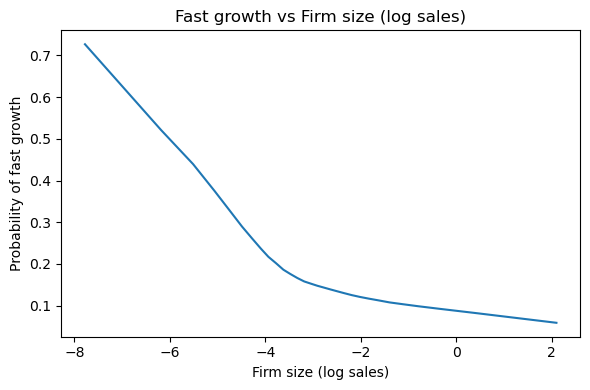

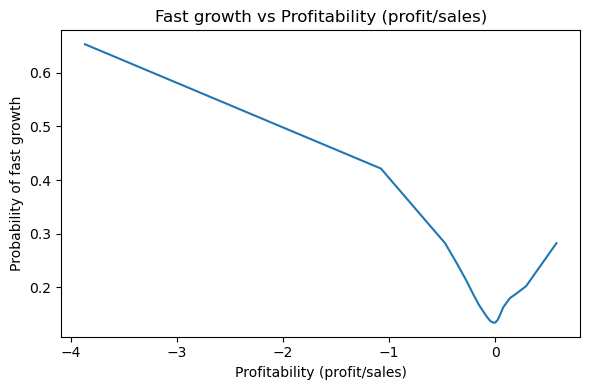

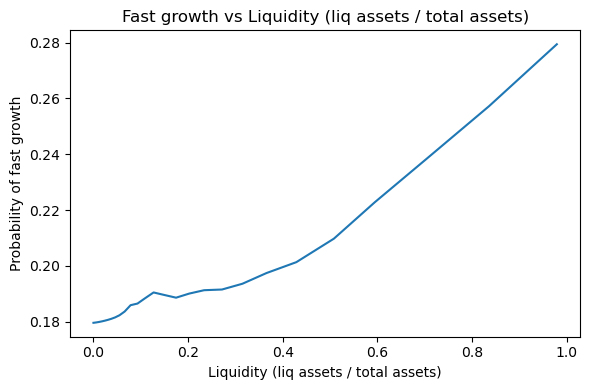

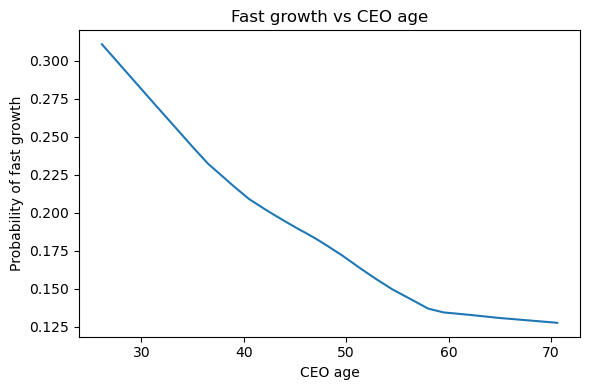

In [ ]:
# LOWESS probability plots

def lowess_prob_plot(data, xvar, yvar=TARGET, xlabel="", n_bins=30, frac=0.6):
    tmp = data[[xvar, yvar]].dropna().copy()
    tmp["pct"] = tmp[xvar].rank(pct=True)
    tmp["bin"] = pd.cut(tmp["pct"], bins=n_bins)

    agg = (
        tmp.groupby("bin", observed=True)
           .agg(x_mean=(xvar, "mean"), p_fast=(yvar, "mean"))
           .reset_index()
    )

    sm = lowess(agg["p_fast"], agg["x_mean"], frac=frac)

    plt.figure(figsize=(6,4))
    plt.plot(sm[:, 0], sm[:, 1])
    plt.xlabel(xlabel if xlabel else xvar)
    plt.ylabel("Probability of fast growth")
    plt.title(f"Fast growth vs {xlabel if xlabel else xvar}")
    plt.tight_layout()
    plt.show()

for x, lab in [
    ("ln_sales_mil", "Firm size (log sales)"),
    ("profit_loss_year_pl", "Profitability (profit/sales)"),
    ("liq_assets_bs", "Liquidity (liq assets / total assets)"),
    ("ceo_age", "CEO age"),
]:
    if x in df.columns:
        lowess_prob_plot(df, x, xlabel=lab)



## Predictor selection

Predictors are selected based on:

• Firm size and age  
• Financial ratios capturing profitability and liquidity  
• Human capital characteristics  
• Industry and regional controls  

These variables are consistent with corporate finance literature on firm growth drivers.

In [7]:
TARGET = "fast_growth"

# Choose predictors (adjust if needed)
CAT_COLS = [c for c in ["ind2_cat", "region_m", "urban_m"] if c in df.columns]

NUM_COLS = [
    "ln_sales_mil", "ln_sales_mil_sq",
    "age", "age2",
    "profit_loss_year_pl", "profit_loss_year_pl_sq",
    "inc_bef_tax_pl",
    "liq_assets_bs", "curr_assets_bs", "fixed_assets_bs", "intang_assets_bs", "share_eq_bs",
    "ceo_age", "ceo_count",
    "foreign_management", "gender_m",
]
NUM_COLS = [c for c in NUM_COLS if c in df.columns]

FLAG_COLS = [c for c in df.columns if c.startswith("flag_miss_")]

PREDICTORS = NUM_COLS + FLAG_COLS + CAT_COLS
print("N predictors:", len(PREDICTORS))
print("Categoricals:", CAT_COLS)

X = df[PREDICTORS].copy()
y = df[TARGET].astype(int).copy()


N predictors: 30
Categoricals: ['ind2_cat', 'region_m', 'urban_m']


In [8]:
# Preprocessing pipelines
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, [c for c in (NUM_COLS + FLAG_COLS) if c in X.columns]),
        ("cat", categorical_pipe, CAT_COLS),
    ],
    remainder="drop"
)


## Building Models

Three classification models are estimated:

1. Logistic Regression (Logit)  
   Provides interpretable baseline results.

2. Random Forest  
   Provides strong predictive performance through ensemble learning.

3. Gradient Boosting  
   Captures nonlinear relationships and interactions.

All models are estimated using cross-validation to ensure robust performance evaluation.

In [9]:
# 1) Logit baseline (L2)
logit = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=3000,
        random_state=RANDOM_STATE
    ))
])
logit_grid = {"model__C": [0.1, 0.3, 1.0, 3.0, 10.0]}

# 2) Random Forest
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=500,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])
rf_grid = {
    "model__max_features": ["sqrt", 0.3, 0.5],
    "model__min_samples_leaf": [1, 3, 5]
}

# 3) Gradient Boosting (as alternative 3rd model)
gb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", GradientBoostingClassifier(random_state=RANDOM_STATE))
])

# Small tuning grid (kept intentionally small)
gb_grid = {
    "model__n_estimators": [200, 400],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [2, 3],
    "model__subsample": [1.0, 0.8],
}

MODELS = {
    "Logit": (logit, logit_grid),
    "Gradient Boosting": (gb, gb_grid),
    "Random Forest": (rf, rf_grid),
}

CV probability performance (AUC)

In [10]:
# Tune each model ONCE using CV AUC

kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

best_estimators = {}
auc_rows = []

for name, (pipe, grid) in MODELS.items():
    search = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring="roc_auc",
        cv=kf,        
        n_jobs=-1,
    )
    search.fit(X, y)

    best_estimators[name] = search.best_estimator_
    auc_rows.append({
        "Model": name,
        "AUC mean": search.best_score_,
        "Best params": search.best_params_
    })

auc_table = pd.DataFrame(auc_rows).sort_values("AUC mean", ascending=False)
display(auc_table)


,Model,AUC mean,Best params
1,Gradient Boosting,0.777489,"{'model__learning_rate': 0.05, 'model__max_dep..."
2,Random Forest,0.772415,"{'model__max_features': 'sqrt', 'model__min_sa..."
0,Logit,0.766128,{'model__C': 0.1}


## Part II: Cost-Based Classification

## LOSS Function

In [13]:
# Business assumption:
# Missing a fast-growth firm is considered 5 times more costly
# than incorrectly flagging a firm as fast-growth.

FP_COST = 1.0   # false positive cost
FN_COST = 5.0   # false negative cost 

In [14]:
# Threshold optimization + expected loss (5-fold CV)
# uses the tuned models (best_estimators)

def expected_loss(y_true, y_pred, fp_cost=FP_COST, fn_cost=FN_COST):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp_cost * fp + fn_cost * fn

thresholds = np.linspace(0.05, 0.95, 91)

loss_rows = []

for name, est in best_estimators.items():
    fold_losses = []
    fold_thrs = []
    fold_aucs = []

    for tr_idx, te_idx in kf.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        est.fit(X_tr, y_tr)
        prob = est.predict_proba(X_te)[:, 1]
        fold_aucs.append(roc_auc_score(y_te, prob))

        best_L = np.inf
        best_t = None
        for t in thresholds:
            pred = (prob >= t).astype(int)
            L = expected_loss(y_te, pred)
            if L < best_L:
                best_L = L
                best_t = t

        fold_losses.append(best_L)
        fold_thrs.append(best_t)

    loss_rows.append({
        "Model": name,
        "AUC (fold mean)": np.mean(fold_aucs),
        "Best threshold mean": np.mean(fold_thrs),
        "Expected loss mean": np.mean(fold_losses),
        "Expected loss std": np.std(fold_losses),
    })

loss_table = pd.DataFrame(loss_rows).sort_values("Expected loss mean")
display(loss_table)



,Model,AUC (fold mean),Best threshold mean,Expected loss mean,Expected loss std
1,Gradient Boosting,0.777489,0.170,1878.8,49.857397
2,Random Forest,0.772415,0.162,1902.2,44.602242
0,Logit,0.766128,0.186,1930.8,66.922044


In [22]:
# Final comparison table (AUC + cost-based performance)

final_table = (
    loss_table[[
        "Model",
        "AUC (fold mean)",
        "Best threshold mean",
        "Expected loss mean",
        "Expected loss std",
    ]]
    .rename(columns={
        "AUC (fold mean)": "AUC",
        "Best threshold mean": "Threshold",
        "Expected loss mean": "Expected loss",
        "Expected loss std": "Loss std",
    })
    .sort_values("Expected loss")
    .reset_index(drop=True)
)

final_table["Predictors"] = len(PREDICTORS)

final_table = final_table.round({
    "AUC": 3,
    "Threshold": 3,
    "Expected loss": 1,
    "Loss std": 1
})
display(final_table)

,Model,AUC,Threshold,Expected loss,Loss std,Predictors
0,Gradient Boosting,0.777,0.170,1878.8,49.9,30
1,Random Forest,0.772,0.162,1902.2,44.6,30
2,Logit,0.766,0.186,1930.8,66.9,30


## PART III: Holdout Evaluation

In [16]:
# Holdout evaluation for the best model

# Create a single holdout set (same for all models)
X_train, X_hold, y_train, y_hold = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

# Select the model with the smallest CV expected loss
best_model_name = loss_table.iloc[0]["Model"]

# Use the CV-optimal threshold for that model
best_thr = float(
    loss_table.loc[loss_table["Model"] == best_model_name, "Best threshold mean"].iloc[0]
)

# Fit the already-tuned estimator on training data
best_model = best_estimators[best_model_name]
best_model.fit(X_train, y_train)

# Holdout predicted probabilities and class labels
prob_hold = best_model.predict_proba(X_hold)[:, 1]
pred_hold = (prob_hold >= best_thr).astype(int)

# Metrics
cm = confusion_matrix(y_hold, pred_hold)
hold_auc = roc_auc_score(y_hold, prob_hold)
hold_loss = expected_loss(y_hold, pred_hold)

print("Selected model:", best_model_name)
print("Threshold used:", round(best_thr, 3))
print("Holdout AUC:", round(hold_auc, 3))
print("Holdout expected loss:", round(hold_loss, 2))
print("\nConfusion matrix [ [TN FP], [FN TP] ]:\n", cm)

Selected model: Gradient Boosting
Threshold used: 0.17
Holdout AUC: 0.777
Holdout expected loss: 2835.0

Confusion matrix [ [TN FP], [FN TP] ]:
 [[3008 1295]
 [ 308  768]]


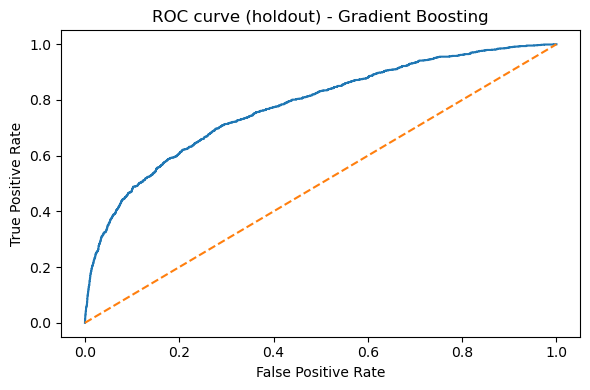

In [24]:
# ROC curve
fpr, tpr, _ = roc_curve(y_hold, prob_hold)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve (holdout) - {best_model_name}")
plt.tight_layout()
plt.show()


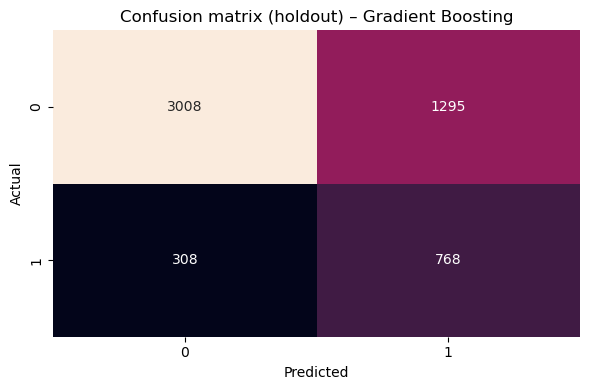

In [23]:
# Confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion matrix (holdout) – {best_model_name}")
plt.tight_layout()
plt.show()

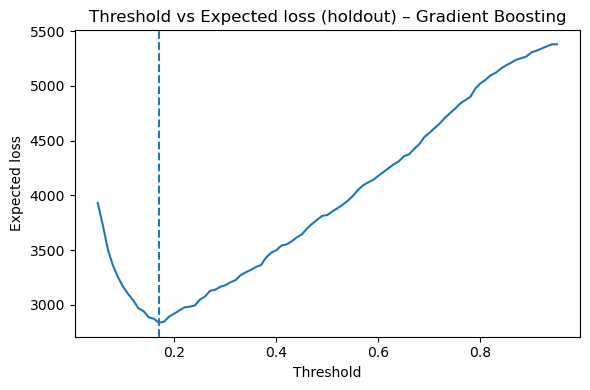

In [19]:
# Threshold vs expected loss curve (holdout)
grid = np.linspace(0.05, 0.95, 91)
loss_curve = []
for t in grid:
    loss_curve.append(expected_loss(y_hold, (prob_hold >= t).astype(int)))

plt.figure(figsize=(6,4))
plt.plot(grid, loss_curve)
plt.axvline(best_thr, linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("Expected loss")
plt.title(f"Threshold vs Expected loss (holdout) – {best_model_name}")
plt.tight_layout()
plt.show()

## TASK 2 Industry Comparison

In [ ]:
# Classification separately for manufacturing vs services

assert "sector" in df.columns, "No 'sector' column found in df."

chosen_model_name = loss_table.iloc[0]["Model"]  # lowest expected loss from Task 1
print("Chosen model for Task 2:", chosen_model_name)
print("Loss function: FP_COST =", FP_COST, "| FN_COST =", FN_COST)

def run_group(df_group, group_name):
    """
    Runs 5-fold CV inside a group (manufacturing/services),
    using the already-tuned chosen model, and selects the threshold
    that minimizes expected loss in each fold.
    """
    Xg = df_group[PREDICTORS].copy()
    yg = df_group[TARGET].astype(int).copy()

    kf_g = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    thresholds = np.linspace(0.05, 0.95, 91)

    fold_losses, fold_thrs, fold_aucs = [], [], []

    for tr_idx, te_idx in kf_g.split(Xg, yg):
        X_tr, X_te = Xg.iloc[tr_idx], Xg.iloc[te_idx]
        y_tr, y_te = yg.iloc[tr_idx], yg.iloc[te_idx]

        # Fit tuned model on fold training data
        model = best_estimators[chosen_model_name]
        model.fit(X_tr, y_tr)

        # Predict probabilities on fold test data
        prob = model.predict_proba(X_te)[:, 1]
        fold_aucs.append(roc_auc_score(y_te, prob))

        # Find threshold minimizing expected loss
        best_thr, best_L = None, np.inf
        for t in thresholds:
            pred = (prob >= t).astype(int)
            L = expected_loss(y_te, pred)
            if L < best_L:
                best_L = L
                best_thr = t

        fold_losses.append(best_L)
        fold_thrs.append(best_thr)

    return {
        "Group": group_name,
        "N": int(len(df_group)),
        "AUC mean": float(np.mean(fold_aucs)),
        "Expected loss mean": float(np.mean(fold_losses)),
        "Best threshold mean": float(np.mean(fold_thrs)),
    }

task2_table = pd.DataFrame([
    run_group(df[df["sector"] == "manufacturing"], "manufacturing"),
    run_group(df[df["sector"] == "services"], "services")
])

display(task2_table)


Chosen model for Task 2: Gradient Boosting
Loss function: FP_COST = 1.0 | FN_COST = 5.0


,Group,N,AUC mean,Expected loss mean,Best threshold mean
0,manufacturing,45,0.630159,8.2,0.098
1,services,200,0.584186,34.6,0.308
